# Цель
Исследовать поведение пользователей в приложении Quiz Freeze.

# Задачи
Проверить следующие гипотезы.

**Гипотеза 1:** Влияет ли обучение на скорость прохождения других этапов игры?

**Гипотеза 2:** Влияет ли на оплату повторное обучение?

**Гипотеза 3:** Если пользователь сначала выбирает уровень сложности вопросов, будет ли он потом проходить обучение?

# Предварительные шаги

Импортируем библиотеку и исходные данные. 

In [1]:
import pandas as pd
events = pd.read_csv('7_4_Events.csv')
purchase = pd.read_csv('purchase.csv')


# На всякий случай работать будем с копиями исходных таблиц.
events_df = events.copy()
purchase_df = purchase.copy()

Поскольку мы уже знакомы с данными, сразу проведем с ними дополнительные преобразования: преобразуем даты в формат datetime и оставим записи только по пользователям, зарегистрировавшимся в 2018 году.

In [2]:
# Преобразуем даты в формат datetime.
events_df['start_time'] = pd.to_datetime(events_df['start_time'], errors='coerce')
purchase_df['event_datetime'] = pd.to_datetime(purchase_df['event_datetime'])

In [3]:
# Сначала создаем список пользователей, зарегистрировавшихся в 2018 году.
cond_1 = events_df['event_type'] == 'registration'
cond_2 = events_df['start_time'] >= '2018-01-01'
cond_3 = events_df['start_time'] < '2019-01-01'
registered_in_2018 = events_df[cond_1 & cond_2 & cond_3]['user_id'].to_list()


# Сставляем в таблицах только нужные записи.
events_df = events_df[events_df['user_id'].isin(registered_in_2018)]
purchase_df = purchase_df[purchase_df['user_id'].isin(registered_in_2018)]

Изучим обновленные датафреймы.

In [4]:
events_df.head()

,id,event_type,selected_level,start_time,tutorial_id,user_id
51405,80308,registration,NaN,2018-01-01 03:48:40,NaN,27832
51406,80309,registration,NaN,2018-01-01 04:07:25,NaN,27833
51407,80310,registration,NaN,2018-01-01 08:35:10,NaN,27834
51408,80311,registration,NaN,2018-01-01 11:54:47,NaN,27835
51409,80312,registration,NaN,2018-01-01 13:28:07,NaN,27836


In [5]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66959 entries, 51405 to 118364
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              66959 non-null  int64         
 1   event_type      66959 non-null  object        
 2   selected_level  8342 non-null   object        
 3   start_time      66959 non-null  datetime64[ns]
 4   tutorial_id     32954 non-null  float64       
 5   user_id         66959 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 3.6+ MB


In [6]:
events_df['event_type'].unique()

array(['registration', 'tutorial_start', 'tutorial_finish',
       'level_choice', 'pack_choice'], dtype=object)

In [7]:
purchase_df.head()

,id,user_id,event_datetime,amount
1171,16845,27845,2018-01-03 18:53:43,100
1172,16846,27865,2018-01-04 14:46:10,250
1174,16848,27911,2018-01-07 08:19:12,50
1175,16849,27910,2018-01-07 12:11:34,100
1176,16850,27940,2018-01-07 13:16:41,200


In [8]:
purchase_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 1171 to 2778
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              1600 non-null   int64         
 1   user_id         1600 non-null   int64         
 2   event_datetime  1600 non-null   datetime64[ns]
 3   amount          1600 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 62.5 KB


Поскольку все проверяемые гипотезы связаны с анализом пользовательских путей, а покупка платных вопросов тоже является одним из событий, следует объединить датафреймы.

In [9]:
# Добавим в датафрейм purchase_df столбец event_type, чтобы
# однозначно выделить события оплаты в объединенном датафрейме.
purchase_df['event_type'] = 'purchase'

# Переименуем столбцы с одинакомыми названиями.
events_df = events_df.rename(columns={'id': 'event_id'})
purchase_df = purchase_df.rename(columns={'id': 'purchase_id'})

# Также переименуем столбец start_time, чтобы время покупок и остальных событий были в одном столбце.
events_df = events_df.rename(columns={'start_time': 'event_datetime'})

#Объединими датафреймы.
total_events_df = pd.concat([events_df, purchase_df], sort=False)

#Сбросим индексы нового датафрейма и отсортируем события по времени.
total_events_df = total_events_df.reset_index(drop=True).sort_values('event_datetime')

total_events_df.head()

,event_id,event_type,selected_level,event_datetime,tutorial_id,user_id,purchase_id,amount
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN


In [10]:
total_events_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68559 entries, 0 to 68558
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   event_id        66959 non-null  float64       
 1   event_type      68559 non-null  object        
 2   selected_level  8342 non-null   object        
 3   event_datetime  68559 non-null  datetime64[ns]
 4   tutorial_id     32954 non-null  float64       
 5   user_id         68559 non-null  int64         
 6   purchase_id     1600 non-null   float64       
 7   amount          1600 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 4.7+ MB


In [11]:
total_events_df['event_type'].unique()

array(['registration', 'tutorial_start', 'tutorial_finish',
       'level_choice', 'pack_choice', 'purchase'], dtype=object)

# Проверка гипотезы 1

***Влияет ли обучение на скорость прохождения других этапов игры?***

Чтобы узнать это, необходимо сравнить время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение. Если показатель отличается, выяснить насколько.


In [12]:
# Найдем группу пользователей, завершивших обучение.
users_finished_tutorial = total_events_df[
    total_events_df['event_type'] == 'tutorial_finish']['user_id'].unique()
set_users_finished_tutorial = set(users_finished_tutorial)

# Найдем группу пользователей, не начинавших обучение.
# Для этого вычтем из всех пользователей тех, кто начинал обучение.
all_users = total_events_df['user_id'].unique()
set_all_users = set(all_users)

users_started_tutorial = total_events_df[
    total_events_df['event_type'] == 'tutorial_start']['user_id'].unique()
set_users_started_tutorial = set(users_started_tutorial)

set_users_without_tutorial = set_all_users.difference(set_users_started_tutorial)

In [13]:

# Создадим функцию, определяющую к какой группе относится пользователь.
def identificate_group(user):
    if user in set_users_finished_tutorial:
        return 'finished_tutorial'
    elif user in set_users_without_tutorial:
        return 'without_tutorial'
    else:
        return 'other'

# Применим эту функцию, чтобы создать в датафрейме новый признак.
total_events_df['user_group'] = total_events_df['user_id'].apply(identificate_group)

total_events_df.head()    

,event_id,event_type,selected_level,event_datetime,tutorial_id,user_id,purchase_id,amount,user_group
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN,without_tutorial
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN,finished_tutorial
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN,finished_tutorial
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN,finished_tutorial
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN,finished_tutorial


In [14]:
# Убедимся, что в колонке user_group не осталось пустых значений.
total_events_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68559 entries, 0 to 68558
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   event_id        66959 non-null  float64       
 1   event_type      68559 non-null  object        
 2   selected_level  8342 non-null   object        
 3   event_datetime  68559 non-null  datetime64[ns]
 4   tutorial_id     32954 non-null  float64       
 5   user_id         68559 non-null  int64         
 6   purchase_id     1600 non-null   float64       
 7   amount          1600 non-null   float64       
 8   user_group      68559 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(3)
memory usage: 5.2+ MB


Посчитаем для каждой группы скорость прохождения этапов.

Ключевые этапы пути пользователя следующие: регистрация, старт обучения, завершение обучения, выбор уровня сложности вопросов, выбор бесплатных вопросов, покупка платных вопросов.

На практике сценарии пользовательских путей могут быть разными. Поэтому, чтобы не считать временные интервалы между всеми возможными комбинациями событий и получить более наглядные результаты, за точку отсчета всегда будем брать событие registration.

In [15]:
# С помощью сводной таблицы найдем, когда пользователи впервые переходили на каждый этап.
users_events_datetime = total_events_df.pivot_table(
    values='event_datetime',
    index='user_id',
    columns='event_type',
    aggfunc='min'
)

display(users_events_datetime)

event_type,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start
user_id,,,,,,
27832,NaT,NaT,NaT,2018-01-01 03:48:40,NaT,NaT
27833,NaT,NaT,NaT,2018-01-01 04:07:25,2018-01-01 17:50:08,2018-01-01 17:47:40
27834,NaT,NaT,NaT,2018-01-01 08:35:10,2018-01-01 19:48:01,2018-01-01 19:46:11
27835,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT,2018-01-01 11:54:47,2018-01-01 15:06:15,2018-01-01 15:00:51
27836,NaT,NaT,NaT,2018-01-01 13:28:07,2018-01-01 15:42:58,2018-01-01 14:54:40
...,...,...,...,...,...,...
47753,2018-12-31 22:36:19,2018-12-31 22:38:05,NaT,2018-12-31 18:58:55,2018-12-31 20:57:07,2018-12-31 20:54:56
47754,NaT,NaT,NaT,2018-12-31 19:14:08,NaT,NaT
47755,2019-01-01 05:04:52,NaT,NaT,2018-12-31 21:15:14,2019-01-01 00:09:30,2019-01-01 00:08:14


In [16]:
# Найдем длительность перехода на каждый этап.
events = ['tutorial_start', 'tutorial_finish', 'level_choice', 'pack_choice', 'purchase']
for event in events:
    users_events_datetime['td_{}'.format(event)] = users_events_datetime[event] - users_events_datetime['registration']

# Уберем лишние столбцы.
users_events_td = users_events_datetime.drop(
    ['registration', 'tutorial_start', 'tutorial_finish', 'level_choice', 'pack_choice', 'purchase'], axis=1)

In [17]:
users_events_td.head()

event_type,td_tutorial_start,td_tutorial_finish,td_level_choice,td_pack_choice,td_purchase
user_id,,,,,
27832,NaT,NaT,NaT,NaT,NaT
27833,0 days 13:40:15,0 days 13:42:43,NaT,NaT,NaT
27834,0 days 11:11:01,0 days 11:12:51,NaT,NaT,NaT
27835,0 days 03:06:04,0 days 03:11:28,0 days 08:42:35,0 days 08:43:56,NaT
27836,0 days 01:26:33,0 days 02:14:51,NaT,NaT,NaT


In [18]:
# Теперь построим окончательную сводную таблицу, чтобы оценить интервалы для групп пользователей.
# Сначала добавим столбцы user_id и user_group.
users_events_td['user_id'] = users_events_datetime.index
users_events_td['user_group'] = users_events_td['user_id'].apply(identificate_group)

# Создадим саму сводную таблицу.
import numpy as np
groups_events_td = users_events_td.groupby(by='user_group')[
    ['td_tutorial_start', 'td_tutorial_finish', 'td_level_choice', 'td_pack_choice', 'td_purchase']
].apply(np.mean)

groups_events_td = groups_events_td.drop('other')

display(groups_events_td)

c:\Users\79057\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


event_type,td_tutorial_start,td_tutorial_finish,td_level_choice,td_pack_choice,td_purchase
user_group,,,,,
finished_tutorial,0 days 04:31:04.938146341,0 days 04:43:18.761268292,0 days 07:05:36.854819357,0 days 07:10:35.660162287,4 days 00:30:03.247408431
without_tutorial,NaT,NaT,0 days 05:15:33.122448979,0 days 05:07:16.175675675,4 days 09:06:01.909090909


Для наглядности представим полученные результаты на столбчатой диаграмме.

In [19]:
# Сначала необходимо преобразовать тип данных в сводной таблице из временного в числовой. 
# За единицу измерения интервалов выберем час.
groups_events_hours_td = round(groups_events_td/pd.Timedelta('1 hour'), 2)
groups_events_hours_td = groups_events_hours_td.fillna(0)

display(groups_events_hours_td)

event_type,td_tutorial_start,td_tutorial_finish,td_level_choice,td_pack_choice,td_purchase
user_group,,,,,
finished_tutorial,4.52,4.72,7.09,7.18,96.5
without_tutorial,0.00,0.00,5.26,5.12,105.1


Для событий tutorial_start и tutorial_finish строить графики нет смысла, так как группа не проходивших обучение по определению не может потратить никакое время для перехода к этим этапам. Поэтому перейдем сразу к сравнению времени прохождения других этапов.

In [20]:
# Импортируем библиотеку.
import matplotlib.pyplot as plt
%matplotlib inline

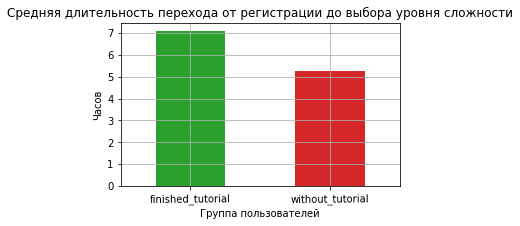

In [21]:
groups_level_choice = groups_events_hours_td['td_level_choice']
groups_level_choice.plot(
    kind='bar',
    figsize=(5, 3),
    title='Средняя длительность перехода от регистрации до выбора уровня сложности',
    grid=True,
    xlabel='Группа пользователей',
    ylabel='Часов',
    rot=0.5,
    color=['tab:green', 'tab:red']
);


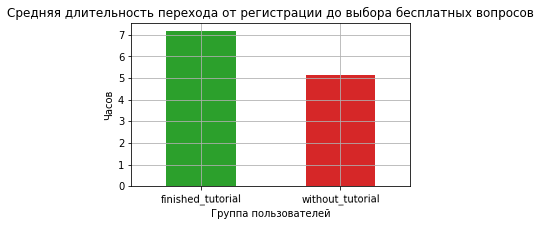

In [22]:
groups_pack_choice = groups_events_hours_td['td_pack_choice']
groups_pack_choice.plot(
    kind='bar',
    figsize=(5, 3),
    title='Средняя длительность перехода от регистрации до выбора бесплатных вопросов',
    grid=True,
    xlabel='Группа пользователей',
    ylabel='Часов',
    rot=0.5,
    color=['tab:green', 'tab:red']
);

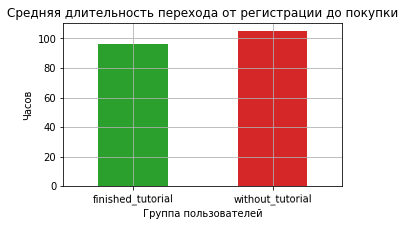

In [23]:
groups_purchase = groups_events_hours_td['td_purchase']
groups_purchase.plot(
    kind='bar',
    figsize=(5, 3),
    title='Средняя длительность перехода от регистрации до покупки',
    grid=True,
    xlabel='Группа пользователей',
    ylabel='Часов',
    rot=0.5,
    color=['tab:green', 'tab:red']
);

**Вывод:** 

Гипотеза 1 подтвердилась. Прохождение обучение влияет на скорость прохождения других этапов игры.

Пользователям, проходившим обучение, в среднем требуется немного больше времени, чтобы перейти от регистрации до выбора уровня сложности и выбора бесплатных вопросов (разница около 2 часов). Однако к оплате они переходят в среднем на 8 часов 36 минут быстрее, чем не проходившие обучение пользователи.


# Проверка гипотезы 2

***Влияет ли на оплату повторное обучение?***

Для этого необходимо сравнить процент оплат для группы пользователей в зависимости от количества законченных обучений.

In [24]:
total_events_df.head()

,event_id,event_type,selected_level,event_datetime,tutorial_id,user_id,purchase_id,amount,user_group
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN,without_tutorial
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN,finished_tutorial
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN,finished_tutorial
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN,finished_tutorial
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN,finished_tutorial


In [25]:
# Создадим сводную таблицу, в которой для каждого пользователя
# будет указано, сколько раз он проходил обучение.
user_finish_count = total_events_df.pivot_table(
    values='tutorial_id',
    index='user_id',
    columns='event_type',
    aggfunc='count',
    fill_value=0
)
user_finish_count = user_finish_count.drop(
    ['registration', 'tutorial_start', 'level_choice', 'pack_choice', 'purchase'],
    axis=1
)
user_finish_count = user_finish_count.rename(columns={'tutorial_finish': 'tutorial_finish_count'})

user_finish_count.head()

event_type,tutorial_finish_count
user_id,
27832,0
27833,1
27834,1
27835,1
27836,1


In [26]:
# Найдем группу пользователей, совершавших покупки.
users_purchase = total_events_df[
    total_events_df['event_type'] == 'purchase']['user_id'].unique()
set_users_purchase = set(users_purchase)

# Найдем группу пользователей, не совершавших покупки.
set_users_without_purchase = set_all_users.difference(set_users_purchase)

In [27]:
# Дополним полученную раннее сводную таблицу.
user_finish_count['user_id'] = user_finish_count.index
user_finish_count['purchase'] = user_finish_count['user_id'].apply(
    lambda x: 'yes' if x in set_users_purchase else 'no'
)

user_finish_count.head()

event_type,tutorial_finish_count,user_id,purchase
user_id,,,
27832,0,27832,no
27833,1,27833,no
27834,1,27834,no
27835,1,27835,no
27836,1,27836,no


In [28]:
# Создадим сводную таблицу, которая позволит проверить гипотезу.
tutorial_finish_purchase = user_finish_count.pivot_table(
    values='user_id',
    index='purchase',
    columns='tutorial_finish_count',
    aggfunc='count'
)

display(tutorial_finish_purchase)

tutorial_finish_count,0,1,2,3,4,5,6,7,8,9
purchase,,,,,,,,,,
no,9523,6872,1139,301,159,98,86,82,48,18
yes,153,1143,182,44,19,19,15,15,6,4


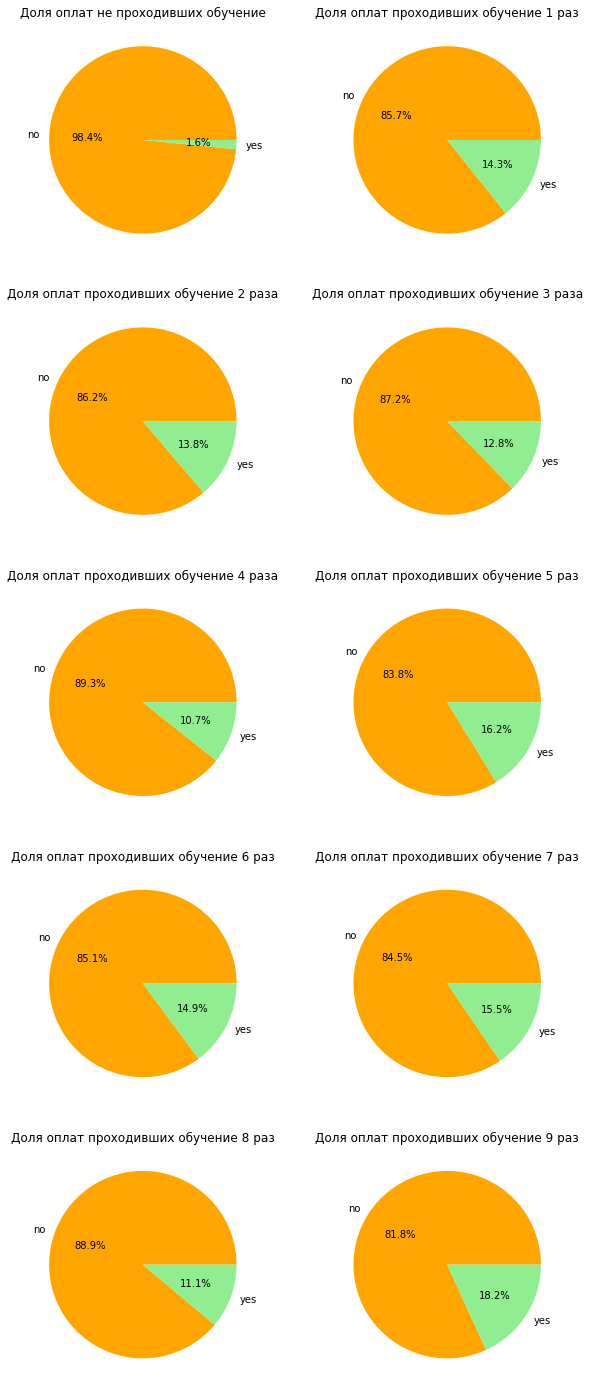

In [29]:
# Строим графики.
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 25))
fig.set_facecolor('white')

axes[0][0].pie(
    tutorial_finish_purchase[0],
    labels=tutorial_finish_purchase.index,
    colors=['orange', 'lightgreen'],
    autopct='%1.1f%%',
)
axes[0][0].set_title('Доля оплат не проходивших обучение')

axes[0][1].pie(
    tutorial_finish_purchase[1],
    labels=tutorial_finish_purchase.index,
    colors=['orange', 'lightgreen'],
    autopct='%1.1f%%',
)
axes[0][1].set_title('Доля оплат проходивших обучение 1 раз')

axes[1][0].pie(
    tutorial_finish_purchase[2],
    labels=tutorial_finish_purchase.index,
    colors=['orange', 'lightgreen'],
    autopct='%1.1f%%',
)
axes[1][0].set_title('Доля оплат проходивших обучение 2 раза')

axes[1][1].pie(
    tutorial_finish_purchase[3],
    labels=tutorial_finish_purchase.index,
    colors=['orange', 'lightgreen'],
    autopct='%1.1f%%',
)
axes[1][1].set_title('Доля оплат проходивших обучение 3 раза')

axes[2][0].pie(
    tutorial_finish_purchase[4],
    labels=tutorial_finish_purchase.index,
    colors=['orange', 'lightgreen'],
    autopct='%1.1f%%',
)
axes[2][0].set_title('Доля оплат проходивших обучение 4 раза')

axes[2][1].pie(
    tutorial_finish_purchase[5],
    labels=tutorial_finish_purchase.index,
    colors=['orange', 'lightgreen'],
    autopct='%1.1f%%',
)
axes[2][1].set_title('Доля оплат проходивших обучение 5 раз')

axes[3][0].pie(
    tutorial_finish_purchase[6],
    labels=tutorial_finish_purchase.index,
    colors=['orange', 'lightgreen'],
    autopct='%1.1f%%',
)
axes[3][0].set_title('Доля оплат проходивших обучение 6 раз')

axes[3][1].pie(
    tutorial_finish_purchase[7],
    labels=tutorial_finish_purchase.index,
    colors=['orange', 'lightgreen'],
    autopct='%1.1f%%',
)
axes[3][1].set_title('Доля оплат проходивших обучение 7 раз')

axes[4][0].pie(
    tutorial_finish_purchase[8],
    labels=tutorial_finish_purchase.index,
    colors=['orange', 'lightgreen'],
    autopct='%1.1f%%',
)
axes[4][0].set_title('Доля оплат проходивших обучение 8 раз')

axes[4][1].pie(
    tutorial_finish_purchase[9],
    labels=tutorial_finish_purchase.index,
    colors=['orange', 'lightgreen'],
    autopct='%1.1f%%',
)
axes[4][1].set_title('Доля оплат проходивших обучение 9 раз');

**Вывод:** 

Гипотеза 2 не подтвердилась. Повторное обучение не влияет на оплату.

Как видно из графиков, между оплатой и количеством обучений, которые завершал пользователь, нет прямой или обратной зависимости. Главное, чтобы пользователи завершили обучение хотя бы один раз. В этих случаях доля оплат (от 10,7% до 18,2%) намного выше по сравнению пользователями, не завершившими обучение ни разу (1,6%).

# Проверка гипотезы 3

***Если пользователь сначала выбирает уровень сложности вопросов, будет ли он потом проходить обучение?***

Для этого необходимо узнать, как часто пользователи начинают обучение после того, как выбрали уровень сложности.

In [30]:
# Снова воспользуемся сводной таблицей users_events_datetime, показывающей, когда пользователи впервые переходили на каждый этап.
# Преобразуем ее в сводную таблицу с интересующими нас пользователями.

# Оставим только нужные столбцы.
users_level_tutorial = users_events_datetime.drop(
    ['pack_choice', 'purchase', 'registration', 'tutorial_finish', 'td_tutorial_start', 'td_tutorial_finish', 'td_level_choice', \
        'td_pack_choice', 'td_purchase'],
    axis=1
)
#users_level_tutorial = users_level_tutorial.fillna(0)

# Оставим только пользователей, у которых есть событие level_choice.
users_level_tutorial = users_level_tutorial.dropna(axis=0, subset='level_choice')

display(users_level_tutorial)

event_type,level_choice,tutorial_start
user_id,,
27835,2018-01-01 20:37:22,2018-01-01 15:00:51
27839,2018-01-01 22:37:50,2018-01-01 19:11:36
27840,2018-01-02 05:18:42,2018-01-02 02:07:07
27842,2018-01-02 08:46:03,2018-01-02 04:55:11
27843,2018-01-02 14:09:58,2018-01-02 13:34:51
...,...,...
47744,2018-12-31 07:53:04,2018-12-31 06:51:17
47747,2018-12-31 12:24:40,2018-12-31 10:21:11
47753,2018-12-31 22:36:19,2018-12-31 20:54:56


In [31]:
# Найдем разницу во времени между выбором уровня сложности и началом обучения. 
users_level_tutorial['difference'] = users_level_tutorial['level_choice'] - users_level_tutorial['tutorial_start']
display(users_level_tutorial)

event_type,level_choice,tutorial_start,difference
user_id,,,
27835,2018-01-01 20:37:22,2018-01-01 15:00:51,0 days 05:36:31
27839,2018-01-01 22:37:50,2018-01-01 19:11:36,0 days 03:26:14
27840,2018-01-02 05:18:42,2018-01-02 02:07:07,0 days 03:11:35
27842,2018-01-02 08:46:03,2018-01-02 04:55:11,0 days 03:50:52
27843,2018-01-02 14:09:58,2018-01-02 13:34:51,0 days 00:35:07
...,...,...,...
47744,2018-12-31 07:53:04,2018-12-31 06:51:17,0 days 01:01:47
47747,2018-12-31 12:24:40,2018-12-31 10:21:11,0 days 02:03:29
47753,2018-12-31 22:36:19,2018-12-31 20:54:56,0 days 01:41:23


In [32]:
users_level_tutorial.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8342 entries, 27835 to 47756
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype          
---  ------          --------------  -----          
 0   level_choice    8342 non-null   datetime64[ns] 
 1   tutorial_start  8244 non-null   datetime64[ns] 
 2   difference      8244 non-null   timedelta64[ns]
dtypes: datetime64[ns](2), timedelta64[ns](1)
memory usage: 260.7 KB


Если пользователь начал обучение после выбора уровня сложности, значение difference должно быть отрицательным.

Если пользователь начал обучение до выбора уровня сложности, значение difference должно быть положительным.

Если пользователь не начинал обучение вообще, в столбце difference должно быть пустое значение.

Остается распределить пользователей по соответствующим группам и посчитать их количество.

In [33]:
# Сделаем это с помощью цикла.
level_before_tutorial_count = 0
tutorial_before_level_count =0
level_without_tutorial_count = 0

# Также необходимо изменить тип данных в столбце difference.
users_level_tutorial['difference'] = round(users_level_tutorial['difference']/pd.Timedelta('1 hour'), 2)

for dif in users_level_tutorial['difference']:
    if dif < 0:
        level_before_tutorial_count += 1
    elif dif > 0:
        tutorial_before_level_count += 1
    else:
        level_without_tutorial_count += 1
        
print('{} пользователей начали обучение после выбора уровня сложности.'.format(level_before_tutorial_count))
print('{} пользователей начали обучение до выбора уровня сложности.'.format(tutorial_before_level_count))
print('{} пользователей выбрали уровень сложности, но не начали обучение.'.format(level_without_tutorial_count))


0 пользователей начали обучение после выбора уровня сложности.
8244 пользователей начали обучение до выбора уровня сложности.
98 пользователей выбрали уровень сложности, но не начали обучение.


**Вывод:**

Гипотеза 3 не подтвердилась. Если пользователь сначала выбирает уровень сложности, проходить обучение он потом не будет.

В изучаемой выборке ни один из пользователей не начал обучение после выбора уровня сложности. Напротив, свыше 98% из 8342 пользователей, выбравших уровень сложности, предварительно начинали обучение. Это означает, что процесс взаимодействия с игрой прозрачен.

#  Итог

Соберем воедино все результаты.

**Гипотеза 1:** ***Влияет ли обучение на скорость прохождения других этапов игры?***

Прохождение обучение ***влияет*** на скорость прохождения других этапов игры. Пользователям, проходившим обучение, в среднем требуется немного больше времени, чтобы перейти от регистрации до выбора уровня сложности и выбора бесплатных вопросов (разница около 2 часов). Однако ***к оплате прошедшие обучение пользователи переходят*** в среднем на 8 часов 36 минут ***быстрее***, чем не проходившие обучение пользователи.

**Гипотеза 2:** ***Влияет ли на оплату повторное обучение?***

***Между оплатой и количеством обучений нет прямой или обратной зависимости.*** Главное, чтобы пользователи завершили обучение хотя бы один раз. В этих случаях доля оплат (от 10,7% до 18,2%) намного выше по сравнению пользователями, не завершившими обучение ни разу (1,6%).

**Гипотеза 3:** ***Если пользователь сначала выбирает уровень сложности вопросов, будет ли он потом проходить обучение?***

Скорее всего, ***нет***. В изучаемой выборке ни один из пользователей не начал обучение после выбора уровня сложности. Напротив, свыше 98% из 8342 пользователей, выбравших уровень сложности, предварительно начинали обучение. Это означает, что процесс взаимодействия с игрой прозрачен.